In [15]:
import cv2
import mediapipe as mp
import numpy as np
mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose
from matplotlib import axes
import matplotlib.pyplot as plt
import scipy.ndimage
from skimage.morphology.binary import binary_dilation, binary_erosion , binary_closing, binary_opening
from skimage.measure import find_contours
from skimage.transform import probabilistic_hough_line
from skimage.feature import corner_harris, corner_peaks, canny
import skimage.io as io
from skimage.color import rgb2gray


import os

mp_hands = mp.solutions.hands

In [16]:
def find_shelves(image):
      im = rgb2gray(image)
      print("shape after",im.shape)
      fig, ax = plt.subplots()
      ax.imshow(im)
      ax.axis('image')
      plt.show()
    
      relief = im.mean(axis=1)

      smoothed = scipy.ndimage.gaussian_filter(im, sigma=5)

      invv=1-im
      difff= invv-smoothed
      fid= smoothed - invv
      # show_images([smoothed, invv, difff, fid],["", "", "", ""])
      horizontal_kernel = np.ones((1,150), np.uint8)
      # print(difff)
      fid = fid > 0.5
      for i in range(50): Horizontal_Image = binary_erosion(fid, horizontal_kernel)

      shelf_Contours = find_contours(Horizontal_Image)

      HLines=len(shelf_Contours)//2



      # Line finding using the Probabilistic Hough Transform
      image = Horizontal_Image
      edges = canny(image, 2)
      lines = probabilistic_hough_line(edges, threshold=10, line_length=5,
                                    line_gap=3)


      y_points=[]
      for line in lines:
            p0, p1 = line
            y_points.append(p0[1])

      return( max(y_points))


      
      
def check_hand_on_shelf(shelf_Contours,wrist_x,wrist_y):
      
     
      if wrist_y<=1.03*shelf_Contours  :
            return True
      return False
            

In [17]:
def calculate_angle(a,b,c):
    a = np.array(a) # First
    b = np.array(b) # Mid
    c = np.array(c) # End
    
    radians = np.arctan2(c[1]-b[1], c[0]-b[0]) - np.arctan2(a[1]-b[1], a[0]-b[0])
    angle = np.abs(radians*180.0/np.pi)
    
    if angle >180.0:
        angle = 360-angle
        
    return angle 

In [18]:
#=============================Hand angle calculation===================================


In [19]:
def get_label(index, hand, results,frame_height,frame_width):
    output = None
    for idx, classification in enumerate(results.multi_handedness):
        if classification.classification[0].index == index:
            
            # Process results
            label = classification.classification[0].label
            score = classification.classification[0].score
            text = '{} {}'.format(label, round(score, 2))
            #print(label)
            if label=="Left":
                text="Right"
            else:
                text="Left"
            # Extract Coordinates
            coords = tuple(np.multiply(
                np.array((hand.landmark[mp_hands.HandLandmark.WRIST].x, hand.landmark[mp_hands.HandLandmark.WRIST].y)),
            [frame_width,frame_height]).astype(int))
            
            output = text, coords
            
    return output

In [20]:

joint_list = [[8,7,6],[12,11,10],[16,15,14]]

def draw_finger_angles(image, results, joint_list,text,hand):
    
    # Loop through hands
        angles=[]
        #Loop through joint sets 
        for joint in joint_list:
            a = np.array([hand.landmark[joint[0]].x, hand.landmark[joint[0]].y]) # First coord
            b = np.array([hand.landmark[joint[1]].x, hand.landmark[joint[1]].y]) # Second coord
            c = np.array([hand.landmark[joint[2]].x, hand.landmark[joint[2]].y]) # Third coord
         
            radians = np.arctan2(c[1] - b[1], c[0]-b[0]) - np.arctan2(a[1]-b[1], a[0]-b[0])
            angle = np.abs(radians*180.0/np.pi)
            
            if angle > 180.0:
                angle = 360-angle
                angles.append(angle)
        if np.mean(angles)<=165:
                #cv2.putText(image,text+" Object in hand" , (10, 60), cv2.FONT_HERSHEY_SIMPLEX,
                               #     1, (0, 0, 255), 3)
            return True 
        else:
                #cv2.putText(image,text+" No object in hand" , (10, 90), cv2.FONT_HERSHEY_SIMPLEX,
                                  #  1, (0, 0, 255), 3)
            return False
            #cv2.putText(image, str(round(angle, 2)), tuple(np.multiply(b, [920, 680]).astype(int)),
                       #cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2, cv2.LINE_AA)
    

In [21]:
import numpy as np

class KalmanFilter:
    def __init__(self, dt, process_noise_covariance, measurement_noise_covariance):
        self.dt = dt
        self.process_noise_covariance = process_noise_covariance
        self.measurement_noise_covariance = measurement_noise_covariance
        self.state = np.zeros((4, 1))
        self.covariance = np.eye(4)
        self.transition_matrix = np.array([[1, 0, dt, 0],
                                           [0, 1, 0, dt],
                                           [0, 0, 1, 0],
                                           [0, 0, 0, 1]])
        self.observation_matrix = np.array([[1, 0, 0, 0],
                                            [0, 1, 0, 0]])

    def predict(self):
        self.state = self.transition_matrix @ self.state
        self.covariance = self.transition_matrix @ self.covariance @ self.transition_matrix.T + self.process_noise_covariance
        return self.state

    def correct(self, measurement):
        innovation = measurement - self.observation_matrix @ self.state
        innovation_covariance = self.observation_matrix @ self.covariance @ self.observation_matrix.T + self.measurement_noise_covariance
        kalman_gain = self.covariance @ self.observation_matrix.T @ np.linalg.inv(innovation_covariance)
        self.state = self.state + kalman_gain @ innovation
        self.covariance = (np.eye(4) - kalman_gain @ self.observation_matrix) @ self.covariance

        return self.state



In [22]:

def isRectangleOverlap( R1, R2):
      if (R1[0]>=R2[2]) or (R1[2]<=R2[0]) or (R1[3]<=R2[1]) or(R1[1]>=R2[3]):
         return False
      else:
        return True
def getArea(R1):
    return (R1[2]-R1[0])* (R1[3]-R1[1])
def save_frames(imp_frames):
        try:
            # creating a folder named data
            if not os.path.exists('screenshots'):
                os.makedirs('screenshots')

              # if not created then raise error
        except OSError:
            print ('Error: Creating directory of data')
        for counter, img in enumerate(imp_frames):
      
            name = './screenshots/frame' + str(counter) + '.jpg'

		# writing the extracted images
            cv2.imwrite(name, img)

1114
shape after (680, 1114)


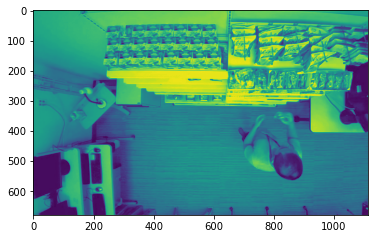

c:\Users\ARWA\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\ARWA\anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [23]:
filename = 'F:\\Graduation-Project\\key_frame_extraction_public-master\\key_frame_extraction_public-master\\1_1_crop.mp4'
filename2='F:\\Graduation-Project\\Videos_MERL_Shopping_Dataset\\23_3_crop.mp4'
filename3="test_video.mp4"
cap = cv2.VideoCapture(filename3)
frame_width = int( cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height =int( cap.get( cv2.CAP_PROP_FRAME_HEIGHT))
print(frame_width)
# fourcc = cv2.VideoWriter_fourcc('X','V','I','D')
# out = cv2.VideoWriter("output.avi", fourcc, 5.0, (1280,720))
ret, frame1 = cap.read()# 1st frame
ret, frame2 = cap.read() #2nd frame

tracked_position = np.zeros((2, 1), dtype=np.float32)
process_noise_covariance = np.eye(4) * 0.1
measurement_noise_covariance = np.eye(2) * 0.2
# Time step
dt = 1.0
kalman = KalmanFilter(dt, process_noise_covariance, measurement_noise_covariance)
# Initialize Kalman filter
# kf = cv2.KalmanFilter(4, 2)
# kf.transitionMatrix = F
# kf.measurementMatrix = H
# kf.processNoiseCov = Q
# kf.measurementNoiseCov = R
# Skin color range (adjust based on your environment and lighting conditions)
skin_lower = np.array([0, 50, 70], dtype=np.uint8)
skin_upper = np.array([20, 150, 255], dtype=np.uint8)

# Open video capture

counterObj=0
counter_onShelf=0
counter_awayShelf=0
counterT=2
shelf_Contours=find_shelves(frame2)
cropped_photos=[]
with mp_hands.Hands(min_detection_confidence=0.5, min_tracking_confidence=0.5) as hands:
    with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose : 
    
        while cap.isOpened():
            counterT+=1
            # BGR 2 RGB
            frame_snip=frame1.copy()
            image = cv2.cvtColor(frame1, cv2.COLOR_BGR2RGB)
            
            # Flip on horizontal
            #image = cv2.flip(image, 1)
            
            # Set flag
            image.flags.writeable = False
            
            # Detections
            results = hands.process(image)
            head=pose.process(image)
            landmarks=0
            try:
                landmarks = head.pose_landmarks.landmark
            except:
                pass
            # Set flag to true
            image.flags.writeable = True
            
            # RGB 2 BGR
            image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)


            diff = cv2.absdiff(frame1, frame2)        
            gray = cv2.cvtColor(diff, cv2.COLOR_BGR2GRAY)        
            blur = cv2.GaussianBlur(gray, (5,5), 0)        
            _, thresh = cv2.threshold(blur, 20, 255, cv2.THRESH_BINARY)        
            dilated = cv2.dilate(thresh, None, iterations=3)        
            contours, _ = cv2.findContours(dilated, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE) 

                # Convert frame to HSV color space
            hsv = cv2.cvtColor(frame1, cv2.COLOR_BGR2HSV)

            # Apply skin color segmentation
            mask = cv2.inRange(hsv, skin_lower, skin_upper)

            # Perform morphological operations to clean up the mask
            kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7))
            mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
            mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

            # Find contours in the mask
            contours_Kalmen, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

            # Filter contours based on area
            min_contour_area = 1000
            filtered_contours = [cnt for cnt in contours_Kalmen if cv2.contourArea(cnt) > min_contour_area]
            updated_pos=(0, 0)
            # Get the hand contours 
            if filtered_contours:
                hand_contour = max(filtered_contours, key=cv2.contourArea)
                # print(hand_contour.shape, hand_contour[1,0,1])
                cenX = np.mean(hand_contour[:, :, 0])
                cenY = np.mean(hand_contour[:, :, 1])
                width = max(hand_contour[:, :, 0]) - min(hand_contour[:, :, 0])
                height = max(hand_contour[:, :, 1]) - min(hand_contour[:, :, 1])
                # print(cenX, cenY)
                measurement = np.array([[cenX], [cenY]], dtype=np.float32)
            # Apply Kalman filter prediction state
                predicted_state = kalman.predict()

                # Apply step of correction in Kalmen filter to the new measurments
                kalman.correct(np.array([[cenX], [cenY]], dtype=np.float32))
                updated_pos = (int(kalman.state[0]), int(kalman.state[1]))
                # Get the updated position
                updatedX=updated_pos[0]-(width/2)
                updatedY=updated_pos[1]-(height/2)
                cv2.circle(frame1, (int( min(hand_contour[:, :, 0])),int( min(hand_contour[:, :, 1]))), 5, (0, 255, 255), -1)
                #print(min(hand_contour[:, :, 1]), updatedY,updated_pos[1],  updated_pos)
                hand_check=check_hand_on_shelf(shelf_Contours,updatedX,updatedY)
                            
                if hand_check==True:
                    counter_onShelf+=1
                    cv2.putText(frame1," Hand on shelf" + str(counter_onShelf), (10, 20), cv2.FONT_HERSHEY_SIMPLEX,
                                            1, (0, 0, 255), 3)
                else:
                    counter_awayShelf+=1
                    cv2.putText(frame1," Hand away from shelf" + str(counter_awayShelf), (10, 20), cv2.FONT_HERSHEY_SIMPLEX,
                                            1, (0, 0, 255), 3)
                # Visualize tracked position on the frame
                cv2.circle(frame1, updated_pos, 5, (0, 255, 0), -1)
                cv2.drawContours(frame1, [hand_contour], -1, (0, 255, 0), 2)
            # Detections
            #print(results)
            text, coord ="",""
            # Rendering results
            wrist_left=tuple()
            wrist_right=tuple()
            object_in_hand=[]
            object_in_hand_flag=False
            if results.multi_hand_landmarks:
                for num, hand in enumerate(results.multi_hand_landmarks):
                    # mp_drawing.draw_landmarks(image, hand, mp_hands.HAND_CONNECTIONS, 
                                            # mp_drawing.DrawingSpec(color=(121, 22, 76), thickness=2, circle_radius=4),
                                            # mp_drawing.DrawingSpec(color=(250, 44, 250), thickness=2, circle_radius=2),)
                    
                
                    # Render left or right detection
                    if get_label(num, hand, results,frame_height,frame_width):
                        text, coord = get_label(num, hand, results,frame_height,frame_width)
                    if text=="Right":
                        wrist_right= (int(hand.landmark[0].x*frame_width), int(hand.landmark[0].y*frame_height))
                        cv2.circle(frame1, wrist_right, 5, (0, 0, 255), -1)
                    elif text=="Left":
                        wrist_left= (int(hand.landmark[0].x*frame_width), int(hand.landmark[0].y*frame_height))
                        cv2.circle(frame1, wrist_left, 5, (0, 0, 255), -1)
                    # cv2.putText(image, str(wrist), coord, cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
                    
                    object_in_hand.append( draw_finger_angles(frame1, results, joint_list,text,hand))
                
                if True in object_in_hand:
                    cv2.putText(frame1," Object in hand" , (10, 60), cv2.FONT_HERSHEY_SIMPLEX,1, (0, 0, 255), 3)
                    object_in_hand_flag=True
                    counterObj+=1
                else:
                    cv2.putText(frame1,"No Object in hand" , (10, 60), cv2.FONT_HERSHEY_SIMPLEX,
                                        1, (0, 0, 255), 3)
                    object_in_hand_flag=False
                    

            #Motion detetion---------------       
            for contour in contours:  
                #print("contour ",contour)      
                (x, y, w, h) =  cv2.boundingRect(contour)             
                if cv2.contourArea(contour) < 1500  or cv2.contourArea(contour) >= 4000:                
                    continue   
                flag=0
                R1=[]
                R2=[]
                if wrist_right:
                    distance=((y-wrist_right[1])**2 + (x-wrist_right[0])**2)**0.5
                    #print("wrist",wrist_right)   
                    if wrist_right[0]<=x+w and wrist_right[0]>=x :
                        R1=[x,y,x+w,y+int(distance)]
                        if not wrist_left:            
                            cv2.rectangle(frame1, (x, y), (x+w, y+int(distance)), (0, 255, 0), 2)
                            if object_in_hand_flag:
                                cropped=frame_snip[y:y+int(distance),x:x+w]
                                cropped_photos.append(cropped)
                        flag=1     

                if wrist_left:
                    distance=((y-wrist_left[1])**2 + (x-wrist_left[0])**2)**0.5
         
                    if wrist_left[0]<=x+w and wrist_left[0]>=x:
                        R2=[x,y,x+w,y+int(distance)]
                        if not wrist_right:            
                            cv2.rectangle(frame1, (x, y), (x+w, y+int(distance)), (0, 255, 0), 2)
                            if object_in_hand_flag:
                                cropped=frame_snip[y:y+int(distance),x:x+w]
                                cropped_photos.append(cropped)
                    flag=1
                if wrist_left and wrist_right and R1 and R2:
                    if isRectangleOverlap(R1,R2):
                     
                        if getArea(R1)> getArea(R2):
                            cv2.rectangle(frame1, (R1[0], R1[1]), (R1[2], R1[3]), (0, 255, 0), 2)
                            if object_in_hand_flag:
                                cropped=frame_snip[R1[1]:R1[3],R1[0]:R1[2]]
                                cropped_photos.append(cropped)
                        else:
                            cv2.rectangle(frame1, (R2[0], R2[1]), (R2[2], R2[3]), (0, 255, 0), 2)
                            if object_in_hand_flag:
                                cropped=frame_snip[R2[1]:R2[3],R2[0]:R2[2]]
                                cropped_photos.append(cropped)
                    else:
                        cv2.rectangle(frame1, (R1[0], R1[1]), (R1[2], R1[3]), (0, 255, 0), 2)
                        if object_in_hand_flag:
                            cropped=frame_snip[R1[1]:R1[3],R1[0]:R1[2]]
                            cropped_photos.append(cropped)
                            cv2.rectangle(frame1, (R2[0], R2[1]), (R2[2], R2[3]), (0, 255, 0), 2)
                            cropped=frame_snip[R2[1]:R2[3],R2[0]:R2[2]]
                            cropped_photos.append(cropped)


                            
                if not wrist_left and not wrist_right and flag==0:
                    if landmarks:
                        if  (landmarks[mp_pose.PoseLandmark.NOSE.value].y*frame_height>y+h or landmarks[mp_pose.PoseLandmark.NOSE.value].y*frame_height<y ) and (landmarks[mp_pose.PoseLandmark.NOSE.value].x*frame_width>x+w or landmarks[mp_pose.PoseLandmark.NOSE.value].x*frame_width<x ) and updated_pos[0]<=x+w and updated_pos[0]>=x and updated_pos[1]<=y+h and updated_pos[1]>=y :
                            cv2.rectangle(frame1, (x, y), (x+w, y+h), (0, 255, 0), 2)  
                            if object_in_hand_flag:
                                cropped=frame_snip[y:y+h,x:x+w]
                                cropped_photos.append(cropped)
                #cv2.putText(image, "Status: {}".format('Movement'), (10, 20), cv2.FONT_HERSHEY_SIMPLEX,
                            #1, (0, 0, 255), 3)
            # image = cv2.resize(image, (920,680))
            # out.write(image)
            cv2.imshow('Hand Tracking', frame1)
            frame1 = frame2
            ret, frame2 = cap.read()#read
            if ret==False:
                break
            if cv2.waitKey(10) & 0xFF == ord('q'):
                break
        cap.release()
        cv2.destroyAllWindows()
        


save_frames(cropped_photos)

In [25]:
import os
from PIL import Image
import imagehash

def delete_similar_images(directory, threshold):
    # Get the list of images in the directory
    image_files = sorted([file for file in os.listdir(directory) if file.endswith(('.jpg', '.jpeg', '.png'))])

    # Compare images and delete similar ones
    previous_hash = None
    for image_file in image_files:
        image_path = os.path.join(directory, image_file)
        try:
            # Open and calculate the perceptual hash of the image
            image = Image.open(image_path)
            current_hash = imagehash.average_hash(image)

            # Compare hashes with the threshold
            if previous_hash is not None and current_hash - previous_hash < threshold:
                os.remove(image_path)  # Delete the similar image
                print(f"Deleted: {image_file}")
            else:
                previous_hash = current_hash
        except Exception as e:
            print(f"Error processing {image_file}: {str(e)}")

# Example usage
directory = 'F:\\Graduation-Project\\key_frame_extraction_public-master\\key_frame_extraction_public-master\\screenshots2'
threshold = 35 # Adjust the threshold value as per your requirement
delete_similar_images(directory, threshold)
final_photos=[]
images=os.listdir(directory)
for image in images:
    im=cv2.imread(directory+'\\'+image)
    final_photos.append(im)



As the pie chart shows, time people touch shelves is not high Maybe because there are more varaieties for different products on these shelves so it makes people more hesitant to buy from them. We recommend that trying to display the products on more area so that people be more decisive. 


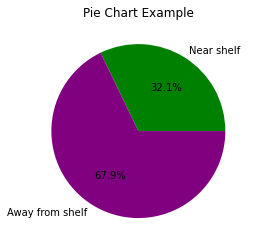

In [26]:
sizes = [counter_onShelf,
counter_awayShelf]  # Sizes or proportions of different categories
labels = ['Near shelf', 'Away from shelf']  # Labels for each category
colors = ['green', 'purple']  # Colors for each category

if 0.8*(counter_awayShelf) < (counter_onShelf):
    print("As the pie chart shows, time people touch shelves is long which indicates that people are certain and have high tendancy to actually grab and buy products on these shelves. We recommend that is you want to let a specific product to be noticed by large number of people to display is on these shelves. ") 
else:
    print("As the pie chart shows, time people touch shelves is not high Maybe because there are more varaieties for different products on these shelves so it makes people more hesitant to buy from them. We recommend that trying to display the products on more area so that people be more decisive. ") 
  
# Create the pie chart
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%')

# Add a title
plt.title('Pie Chart Example')

# Display the chart
plt.show()

<>:8: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<>:8: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
C:\Users\ARWA\AppData\Local\Temp\ipykernel_19604\1162016486.py:8: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
  elif 1.1(counterT-(counter_onShelf+counter_awayShelf)) < (counter_onShelf+counter_awayShelf):


As the bar graph shows, time people pass by and inspects these shelves is long which indicates that people have high interest toward products on these shelves. We recommend that is you want to let a specific product to be noticed by large number of people to display is on these shelves. 


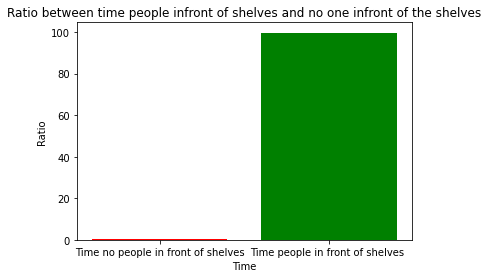

In [27]:
categories = ['Time no people in front of shelves', 'Time people in front of shelves ']  # Categories on the x-axis
values = [((counterT-(counter_onShelf+counter_awayShelf))/counterT)*100 ,( (counter_onShelf+counter_awayShelf)/counterT)*100]  # Values or heights of the bars

# Create the bar graph
plt.bar(categories, values, color=['red',  'green'])
if 1.2*(counterT-(counter_onShelf+counter_awayShelf)) < (counter_onShelf+counter_awayShelf):
    print("As the bar graph shows, time people pass by and inspects these shelves is long which indicates that people have high interest toward products on these shelves. We recommend that is you want to let a specific product to be noticed by large number of people to display is on these shelves. ") 
elif 1.1(counterT-(counter_onShelf+counter_awayShelf)) < (counter_onShelf+counter_awayShelf):
    print("As the bar graph shows, time people pass by and inspects these shelves is not so high which indicates that nearly halve of total time people are not interest toward products on these shelves ") 
else:
    print("As the bar graph shows, time people pass by and inspects these shelves is low which indicates that  people are not interest toward products on these shelves. We recommend that trying to move some products that is essential to most people to be pleced on these shelves so that the other products can be noticed. ") 
  
    
# Add labels and title
plt.xlabel('Time')
plt.ylabel('Ratio')
plt.title('Ratio between time people infront of shelves and no one infront of the shelves')

# Display the graph
plt.show()

As the pie chart shows, time people ispecting products is high  which reflects that people may have high tendancy to buy products from these shelves. 


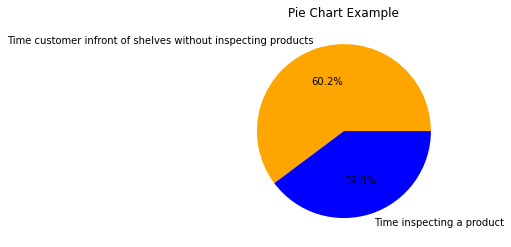

In [28]:
TotalT=counter_onShelf+counter_awayShelf
sizes = [(TotalT-counterObj),
counterObj]  # Sizes or proportions of different categories
labels = ['Time customer infront of shelves without inspecting products', 'Time inspecting a product']  # Labels for each category
colors = ['orange', 'blue']  # Colors for each category

if 0.6*((TotalT-counterObj)) < (counterObj):
    print("As the pie chart shows, time people ispecting products is high  which reflects that people may have high tendancy to buy products from these shelves. ") 
else:
    print("As the pie chart shows, time people ispecting products is relatively not high  which reflects that people are not attracted enough towards products on these shelves. ") 
 
# Create the pie chart
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%')

# Add a title
plt.title('Pie Chart Example')

# Display the chart
plt.show()

In [ ]:
#this array contains cropped images
final_photos